In [20]:
%matplotlib inline
import sys
import glob
import os
import random
import json
import pickle
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

from astropy.table import Table
import rubin_sim.maf.db as db
sys.path.append(os.path.abspath(".."))
from local_opsdb_patch import OpsimDatabase #local
from rubin_sim import maf
from rubin_sim.maf.utils import m52snr
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.plots as plots

import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.metric_bundles as metric_bundles
from astropy.cosmology import z_at_value
from rubin_sim.maf.metrics import BaseMetric
from rubin_sim.maf.slicers import UserPointsSlicer
from rubin_sim.maf.metric_bundles import MetricBundle, MetricBundleGroup
from rubin_sim.maf.db import ResultsDb
import rubin_sim.maf.utils as maf_utils
import rubin_sim.maf.metrics as metrics
from rubin_sim.maf.plots import HealpixSkyMap
import rubin_sim.maf.plots as plots

#from rubin_sim.utils import equatorialFromGalactic, hpid2RaDec, _healbin, healbin
from astropy.coordinates import Galactic, ICRS
import astropy.units as u
import healpy as hp
from scipy.stats import truncnorm


from rubin_sim.phot_utils import DustValues

dust_model = DustValues()
#from rubin_sim.utils import getPackageDir
from importlib import resources

def getPackageDir(pkg_name):
    try:
        return resources.files(pkg_name).parent
    except Exception as e:
        raise RuntimeError(f"Could not find package {pkg_name}: {e}")

In [59]:
import importlib

# Clear the module from cache
if "local_kne_metrics" in sys.modules:
    del sys.modules["local_kne_metrics"]

# Re-import and reload the updated module
import local_kne_metrics
importlib.reload(local_kne_metrics)

# Import updated classes and functions from the refactored module
from local_kne_metrics import (
    KN_lc, KNeDetectMetric, KNeRedColorDetectMetric, KNeBlueColorDetectMetric,
    KNeZTFRestSimpleMetric, KNeZTFRestSimpleRedMetric, KNeZTFRestSimpleBlueMetric,
    KNeMultiColorDetectMetric, generateKNeTemplates, generateKNePopSlicer
)

# Confirm path
print(local_kne_metrics.__file__)


/Users/andradenebula/Documents/Research/Transient_Metrics/Multi_Transient_Metrics_Hub/KNe/local_kne_metrics.py


In [ ]:
#Script Stuff Provided

shared_lc_model = KN_lc(load_from="kne_templates_used.pkl")
slicer = generateKNPopSlicer(load_from="KNe_population_fixedpop_10yr.pkl")

#1. Run all detection metrics
detect_all = df_obs['KNeDetectMetric'] == 1
detect_red = df_obs['KNeRedColorDetectMetric'] == 1
detect_blue = df_obs['KNeBlueColorDetectMetric'] == 1

#2. Apply characterization metrics conditionally
df_obs['KNeZTFRestSimpleMetric_postDetect'] = df_obs['KNeZTFRestSimpleMetric'] & detect_all
df_obs['KNeMultiColorDetectMetric_postDetect'] = df_obs['KNeMultiColorDetectMetric'] & detect_all

df_obs['KNeZTFRestSimpleRedMetric_postDetect'] = df_obs['KNeZTFRestSimpleRedMetric'] & detect_red
df_obs['KNeZTFRestSimpleBlueMetric_postDetect'] = df_obs['KNeZTFRestSimpleBlueMetric'] & detect_blue

#3 Summarize per cadence
n_detect_all = detect_all.sum()
n_char_all = df_obs['KNeZTFRestSimpleMetric_postDetect'].sum()

print(f"Of {n_detect_all} baseline detections, {n_char_all} were characterized by ZTFReST logic.")

#4.kne_metric_groups Dictionary


kne_metric_groups = {
    "KNeDetectMetric": {
        "label": "Baseline Detection",
        "characterization": [
            "KNeZTFRestSimpleMetric",
            "KNeMultiColorDetectMetric"
        ]
    },
    "KNeRedColorDetectMetric": {
        "label": "Red Kilonova Detection",
        "characterization": [
            "KNeZTFRestSimpleRedMetric"
        ]
    },
    "KNeBlueColorDetectMetric": {
        "label": "Blue Kilonova Detection",
        "characterization": [
            "KNeZTFRestSimpleBlueMetric"
        ]
    }
}
#1. Apply Characterization Metrics Conditionally

for detect_metric, info in kne_metric_groups.items():
    detect_mask = df_obs[detect_metric] == 1
    for char_metric in info["characterization"]:
        new_col = f"{char_metric}_postDetect"
        df_obs[new_col] = df_obs[char_metric] & detect_mask
for detect_metric, info in kne_metric_groups.items():
    n_detected = df_obs[detect_metric].sum()
    print(f"\n{info['label']}: {n_detected} events detected")
    for char_metric in info["characterization"]:
        char_col = f"{char_metric}_postDetect"
        n_char = df_obs[char_col].sum()
        print(f"  └ {char_metric}: {n_char} characterized ({n_char / n_detected:.1%})")

#2. Summarize Counts

for detect_metric, info in kne_metric_groups.items():
    n_detected = df_obs[detect_metric].sum()
    print(f"\n{info['label']}: {n_detected} events detected")
    for char_metric in info["characterization"]:
        char_col = f"{char_metric}_postDetect"
        n_char = df_obs[char_col].sum()
        print(f"  └ {char_metric}: {n_char} characterized ({n_char / n_detected:.1%})")



Saved KN light curve templates to kne_templates_used.pkl
Loaded KN light curve templates from kne_templates_used.pkl
Saved KNe population to KNe_output/KNe_population_rd300.pkl


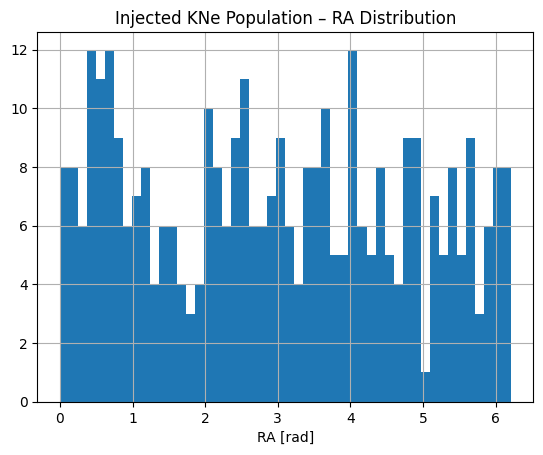

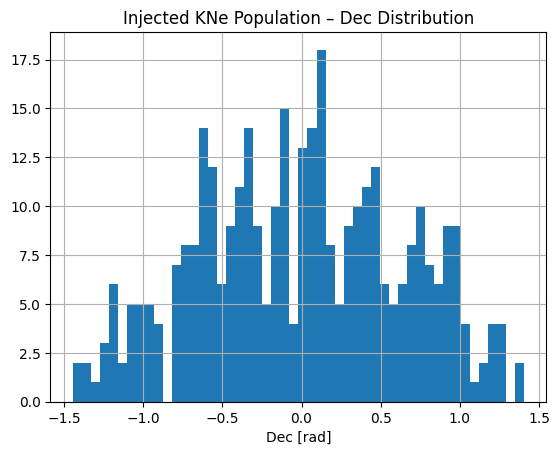

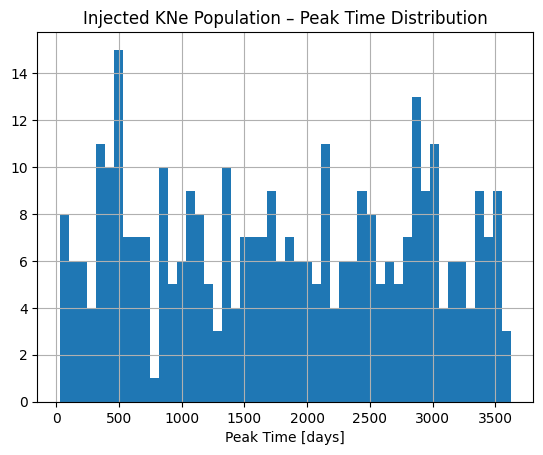

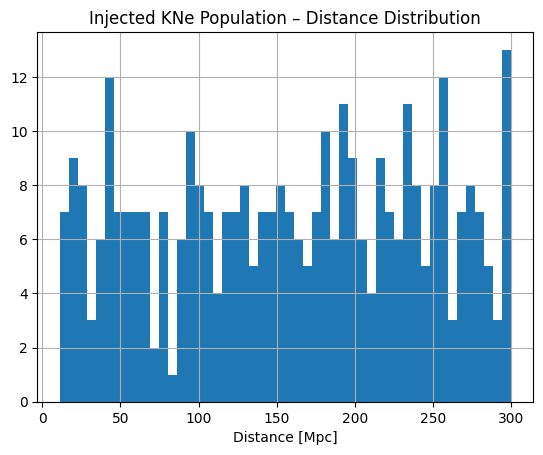

[DEBUG] First 5 RA/Dec (rad): [2.0888249  0.61359232 1.11673801 4.7982919  4.00062189], [ 0.96181493 -0.58486081 -0.3178237   0.12532783  0.13583399]
[DEBUG] SkyCoord sample Dec: [ 55.10793643 -33.51005607 -18.20995686   7.18075578   7.78271439] deg
[DEBUG] SkyCoord Dec units: deg


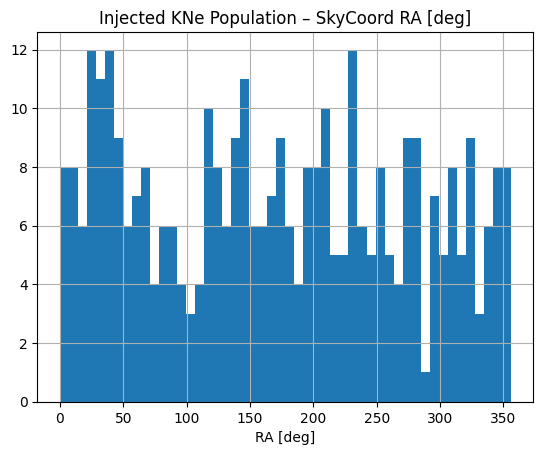

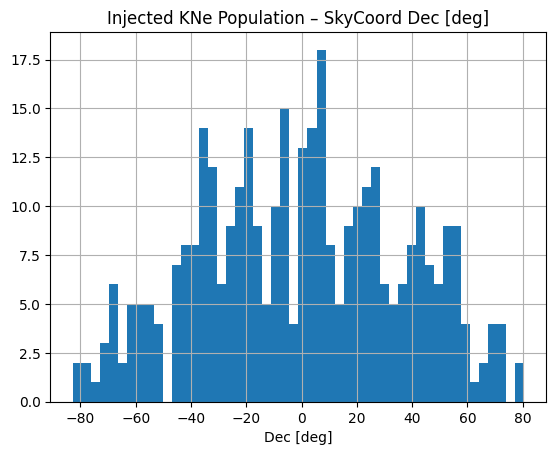

In [60]:
# --- Configuration ---
cadences = ['baseline_v4.3.1_10yrs', 'four_roll_v4.3.1_10yrs']
kne_dir = "KNe_output"
os.makedirs(kne_dir, exist_ok=True)
db_dir = "../"
t_start, t_end = 1, 3652
dmin, dmax = 10, 300
rate_density = 300e-9  # events/Mpc³/yr
template_file = "kne_templates_used.pkl"
pop_file = os.path.join(kne_dir, f"KNe_population_rd{int(rate_density*1e9)}.pkl")

# --- Templates & Population ---
if not os.path.exists(template_file):
    generateKNeTemplates(save_to=template_file)
lc_model = KN_lc(load_from=template_file)

if not os.path.exists(pop_file):
    slicer = generateKNePopSlicer(t_start=t_start, t_end=t_end, d_min=dmin, d_max=dmax,
                                  rate_density=rate_density, save_to=pop_file)
else:
    slicer = generateKNePopSlicer(load_from=pop_file)

n_events = len(slicer.slice_points['distance'])
ax1 = DustValues().ax1


--- Running baseline_v4.3.1_10yrs ---

Inspecting one obs_record before saving to CSV:
mjd_obs         | <class 'numpy.ndarray'> | len: 838
mag_obs         | <class 'numpy.ndarray'> | len: 838
snr_obs         | <class 'numpy.ndarray'> | len: 838
filter          | <class 'numpy.ndarray'> | len: 838
first_det_mjd   | <class 'numpy.float64'> | len: scalar
last_det_mjd    | <class 'numpy.float64'> | len: scalar
fade_time_days  | <class 'numpy.float64'> | len: scalar
sid             | <class 'numpy.int64'> | len: scalar
file_indx       | <class 'numpy.int64'> | len: scalar
ra              | <class 'numpy.float64'> | len: scalar
dec             | <class 'numpy.float64'> | len: scalar
distance_Mpc    | <class 'numpy.float64'> | len: scalar
peak_mjd        | <class 'numpy.float64'> | len: scalar
peak_mag        | <class 'numpy.float64'> | len: scalar
ebv             | <class 'numpy.float32'> | len: scalar
peak_time       | <class 'numpy.float64'> | len: scalar
detected        | <class 'bool'>

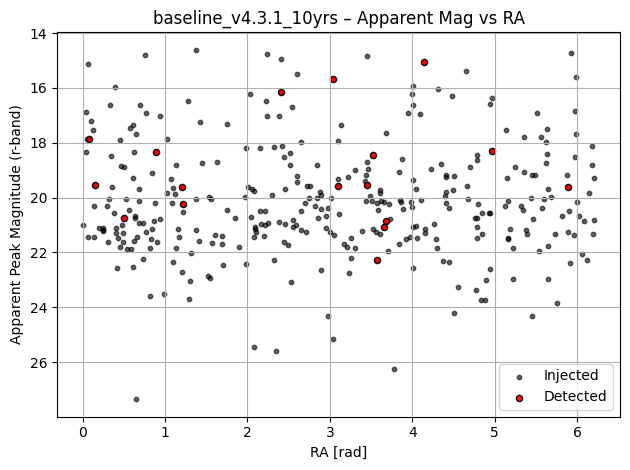

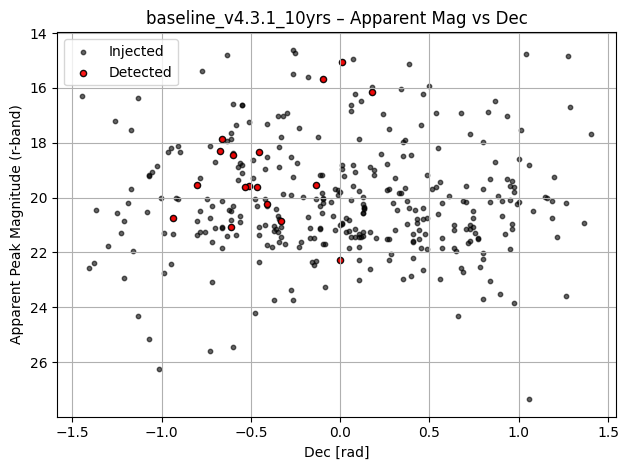

RA min/max (rad): 0.0 6.209554229361076
Dec min/max (rad): -1.4431320581280231 1.404754785725338


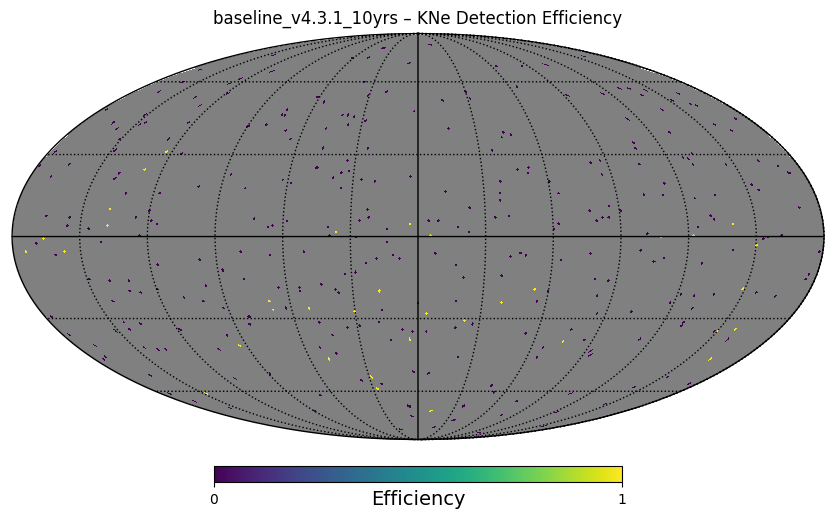

In [ ]:

# --- Main Loop ---
first = 1
kne_summary_all = []

for cadence in cadences:
    print(f"\n--- Running {cadence} ---")
    opsdb = os.path.join(db_dir, f"{cadence}.db")
    outDir = os.path.join(kne_dir, f"results_{cadence}")
    os.makedirs(outDir, exist_ok=True)
    resultsDb = ResultsDb(out_dir=outDir)

    # Detection metrics
    detect = KNeDetectMetric(metric_name="KNe_Detect", lc_model=lc_model)
    bundle = MetricBundle(detect, slicer, '')
    detect_group = MetricBundleGroup({'KNe_Detect': bundle}, opsdb, out_dir=outDir, results_db=resultsDb)
    detect_group.run_all()

    detect_metric = bundle.metric
    obs_records = list(detect_metric.obs_records.values())

    # Create DataFrame before using it
    df_obs = pd.DataFrame.from_dict(detect_metric.obs_records, orient='index')
    df_obs = df_obs.reset_index()

        
    df_obs["year"] = (df_obs["peak_time"] / 365.25).astype(int) + 1
    for col in ['filter', 'mjd_obs', 'mag_obs', 'snr_obs']:
        df_obs[col] = df_obs[col].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

    # ---- Run characterization metrics ----
    char_metrics = OrderedDict()
    char_metrics["ZTFReST"] = KNeZTFRestSimpleMetric(metric_name="KNe_ZTFReST", lc_model=lc_model)
    char_metrics["ZTFReST_Blue"] = KNeZTFRestSimpleBlueMetric(metric_name="KNe_ZTFReST_Blue", lc_model=lc_model)
    char_metrics["ZTFReST_Red"] = KNeZTFRestSimpleRedMetric(metric_name="KNe_ZTFReST_Red", lc_model=lc_model)
    char_metrics["MultiColor"] = KNeMultiColorDetectMetric(metric_name="KNe_MultiColor", lc_model=lc_model)

    for key, char_metric in char_metrics.items():
        # Add new column and set to False first
        df_obs[f"characterized_{key}"] = False
        
        bundle = MetricBundle(char_metric, slicer, '')
        char_group = MetricBundleGroup({key: bundle}, opsdb, out_dir=outDir, results_db=resultsDb)
        char_group.run_all()
  
        for sid, record in bundle.metric.obs_records.items():
            if sid in detect_metric.obs_records:
                df_obs.loc[df_obs['sid'] == sid, f"characterized_{key}"] = True
                
        df_obs.to_csv(f"{kne_dir}/ObsRecords_{cadence}.csv", index=False)


    #Check
    print("\nInspecting one obs_record before saving to CSV:")
    sample = obs_records[0]
    for k, v in sample.items():
        print(f"{k:15} | {type(v)} | len: {len(v) if hasattr(v, '__len__') and not isinstance(v, str) else 'scalar'}")

    # Yearly histogram
    df_detected = df_obs[df_obs['detected'] == True]
    df_detected_per_year = df_detected.groupby("year").size().reset_index(name="n_detected")

    # Apparent magnitude plots
    ras, decs, mags_app, detected_flags = [], [], [], []
    for i in range(n_events):
        ra = slicer.slice_points['ra'][i]
        dec = slicer.slice_points['dec'][i]
        d = slicer.slice_points['distance'][i]
        ebv = slicer.slice_points['ebv'][i]
        file_indx = slicer.slice_points['file_indx'][i]

        mag_peak = np.min(lc_model.data[file_indx]['r']['mag'])
        A = ax1['r'] * ebv
        dm = 5 * np.log10(d * 1e6) - 5
        m_app = mag_peak + dm + A

        ras.append(ra)
        decs.append(dec)
        mags_app.append(m_app)
        detected_flags.append(i in detect_metric.obs_records)

    plt.figure()
    plt.scatter(ras, mags_app, c='black', s=10, label='Injected', alpha=0.6)
    plt.scatter(np.array(ras)[detected_flags], np.array(mags_app)[detected_flags],
                c='red', s=20, label='Detected', alpha=0.9, edgecolors='black')
    plt.xlabel("RA [rad]"); plt.ylabel("Apparent Peak Magnitude (r-band)")
    plt.title(f"{cadence} – Apparent Mag vs RA")
    plt.gca().invert_yaxis(); plt.grid(); plt.legend(); plt.tight_layout(); plt.show()

    plt.figure()
    plt.scatter(decs, mags_app, c='black', s=10, label='Injected', alpha=0.6)
    plt.scatter(np.array(decs)[detected_flags], np.array(mags_app)[detected_flags],
                c='red', s=20, label='Detected', alpha=0.9, edgecolors='black')
    plt.xlabel("Dec [rad]"); plt.ylabel("Apparent Peak Magnitude (r-band)")
    plt.title(f"{cadence} – Apparent Mag vs Dec")
    plt.gca().invert_yaxis(); plt.grid(); plt.legend(); plt.tight_layout(); plt.show()

    print("RA min/max (rad):", slicer.slice_points['ra'].min(), slicer.slice_points['ra'].max())
    print("Dec min/max (rad):", slicer.slice_points['dec'].min(), slicer.slice_points['dec'].max())

    # Efficiency sky map
    nside = slicer.nside if hasattr(slicer, 'nside') else 64
    npix = hp.nside2npix(nside)
    injected_map = np.zeros(npix)
    detected_map = np.zeros(npix)

    ra_rad = slicer.slice_points['ra']
    dec_rad = slicer.slice_points['dec']
    theta = 0.5 * np.pi - dec_rad
    phi = ra_rad
    pix_inds = hp.ang2pix(nside, theta, phi)

    for i, pix in enumerate(pix_inds):
        injected_map[pix] += 1
        if bundle.metric_values[i] == 1:
            detected_map[pix] += 1

    eff_map = np.full(npix, hp.UNSEEN)
    mask = injected_map > 0
    eff_map[mask] = detected_map[mask] / injected_map[mask]

    hp.mollview(eff_map, title=f"{cadence} – KNe Detection Efficiency", unit='Efficiency', cmap='viridis')
    hp.graticule(); plt.show()

    # ---- Characterization Healpix Maps ----
    for key, char_metric in char_metrics.items():
        bundle = MetricBundle(char_metric, slicer, '')
        char_group = MetricBundleGroup({key: bundle}, opsdb, out_dir=outDir, results_db=resultsDb)
        char_group.run_all()

        nside = slicer.nside if hasattr(slicer, 'nside') else 64
        npix = hp.nside2npix(nside)
        injected_map = np.zeros(npix)
        detected_map = np.zeros(npix)

        theta = 0.5 * np.pi - slicer.slice_points['dec']
        phi = slicer.slice_points['ra']
        pix_inds = hp.ang2pix(nside, theta, phi)

        for i, pix in enumerate(pix_inds):
            injected_map[pix] += 1
            if i in bundle.metric.obs_records:
                detected_map[pix] += 1


        eff_map = np.full(npix, hp.UNSEEN)
        mask = injected_map > 0
        eff_map[mask] = detected_map[mask] / injected_map[mask]

        hp.mollview(eff_map, title=f"{cadence} – {key} Characterization Efficiency", unit='Efficiency', cmap='plasma')
        hp.graticule()
        plt.show()


    # Declination histogram
    plt.figure()
    plt.hist(np.degrees(slicer.slice_points['dec']), bins=50, alpha=0.5, label='Injected')
    plt.hist(np.degrees(np.array(decs)[detected_flags]), bins=50, alpha=0.8, color='red', label='Detected')
    plt.xlabel("Declination [deg]"); plt.ylabel("Number of Events")
    plt.title(f"{cadence} – Declination Distribution"); plt.grid(); plt.legend(); plt.tight_layout(); plt.show()

    # Year histogram
    plt.figure()
    plt.hist(df_obs["peak_time"] / 365.25, bins=np.arange(0.5, 11.5, 1), edgecolor='black')
    plt.xticks(ticks=np.arange(1, 11), labels=[f"Year {i}" for i in range(1, 11)])
    plt.xlabel("Survey Year"); plt.ylabel("Number of Events")
    plt.title("Distribution of KNe Peak Times"); plt.grid(); plt.tight_layout(); plt.show()

    # ---- Characterization Per-Year Histograms ----
    for key, char_metric in char_metrics.items():
        char_df = pd.DataFrame.from_dict(char_metric.obs_records, orient='index')
        if not char_df.empty:
            char_df = char_df.reset_index(drop=True)
            char_df["year"] = (char_df["peak_time"] / 365.25).astype(int) + 1
            df_char_per_year = char_df.groupby("year").size().reset_index(name="n_characterized")

            plt.figure(figsize=(8, 4))
            plt.bar(df_char_per_year["year"], df_char_per_year["n_characterized"], edgecolor='black', alpha=0.7)
            plt.xticks(ticks=np.arange(1, 11), labels=[f"Year {i}" for i in range(1, 11)])
            plt.xlabel("Survey Year")
            plt.ylabel("Number of Events")
            plt.title(f"{cadence} – Yearly Histogram: {key} Characterized Events")
            plt.grid(True)
            plt.tight_layout()
            plt.show()
    
    # Mapping using keys from char_metrics dictionary
    metric_map = {
        "KNeDetectMetric": ["ZTFReST", "MultiColor"],
        "KNeRedColorDetectMetric": ["ZTFReST_Red"],
        "KNeBlueColorDetectMetric": ["ZTFReST_Blue"]
    }
    
    detect_metrics = {
        "KNeDetectMetric": detect_metric,
        "KNeRedColorDetectMetric": KNeRedColorDetectMetric(metric_name="KNeRedColorDetect", lc_model=lc_model),
        "KNeBlueColorDetectMetric": KNeBlueColorDetectMetric(metric_name="KNeBlueColorDetect", lc_model=lc_model)
    }
    
    for detect_key, char_keys in metric_map.items():
        d_metric = detect_metrics[detect_key]
        d_sids = set(d_metric.obs_records.keys())
        n_detected = len(d_sids)
        n_injected = len(slicer.slice_points['ra'])
    
        for char_key in char_keys:
            c_metric = char_metrics[char_key]
            c_sids = set(c_metric.obs_records.keys())
            n_char = len(d_sids.intersection(c_sids))
    
            summary_row = {
                "cadence": cadence,
                "detect_metric": detect_key,
                "characterize_metric": char_key,
                "n_injected": n_injected,
                "n_detected": n_detected,
                "n_characterized": n_char,
                "frac_detected": n_detected / n_injected if n_injected else 0,
                "frac_char_given_detect": n_char / n_detected if n_detected else 0
            }

            kne_summary_all.append(summary_row)

# Convert summary list to DataFrame
df_summary = pd.DataFrame(kne_summary_all)

# Save to CSV (overwrite each run)
summary_path = os.path.join(kne_dir, "kne_detection_characterization_summary.csv")
df_summary.to_csv(summary_path, index=False, mode='w')



In [76]:

display(df_summary)

,cadence,detect_metric,characterize_metric,n_injected,n_detected,n_characterized,frac_detected,frac_char_given_detect
0,baseline_v4.3.1_10yrs,KNeDetectMetric,ZTFReST,350,17,10,0.049,0.588
1,baseline_v4.3.1_10yrs,KNeDetectMetric,MultiColor,350,17,14,0.049,0.824
2,baseline_v4.3.1_10yrs,KNeRedColorDetectMetric,ZTFReST_Red,350,0,0,0.000,0.000
3,baseline_v4.3.1_10yrs,KNeBlueColorDetectMetric,ZTFReST_Blue,350,0,0,0.000,0.000
4,four_roll_v4.3.1_10yrs,KNeDetectMetric,ZTFReST,350,16,11,0.046,0.688
5,four_roll_v4.3.1_10yrs,KNeDetectMetric,MultiColor,350,16,13,0.046,0.812
6,four_roll_v4.3.1_10yrs,KNeRedColorDetectMetric,ZTFReST_Red,350,0,0,0.000,0.000
7,four_roll_v4.3.1_10yrs,KNeBlueColorDetectMetric,ZTFReST_Blue,350,0,0,0.000,0.000
8,baseline_v4.3.1_10yrs,KNeDetectMetric,ZTFReST,350,17,10,0.049,0.588
9,baseline_v4.3.1_10yrs,KNeDetectMetric,MultiColor,350,17,14,0.049,0.824


In [ ]:
import matplotlib.pyplot as plt
plt.hist(np.degrees(slicer.slice_points['dec']), bins=50)
plt.xlabel("Dec [deg]"); plt.title("Dec Distribution"); plt.grid(); plt.show()

plt.hist(np.degrees(slicer.slice_points['ra']), bins=50)
plt.xlabel("RA [deg]"); plt.title("RA Distribution"); plt.grid(); plt.show()


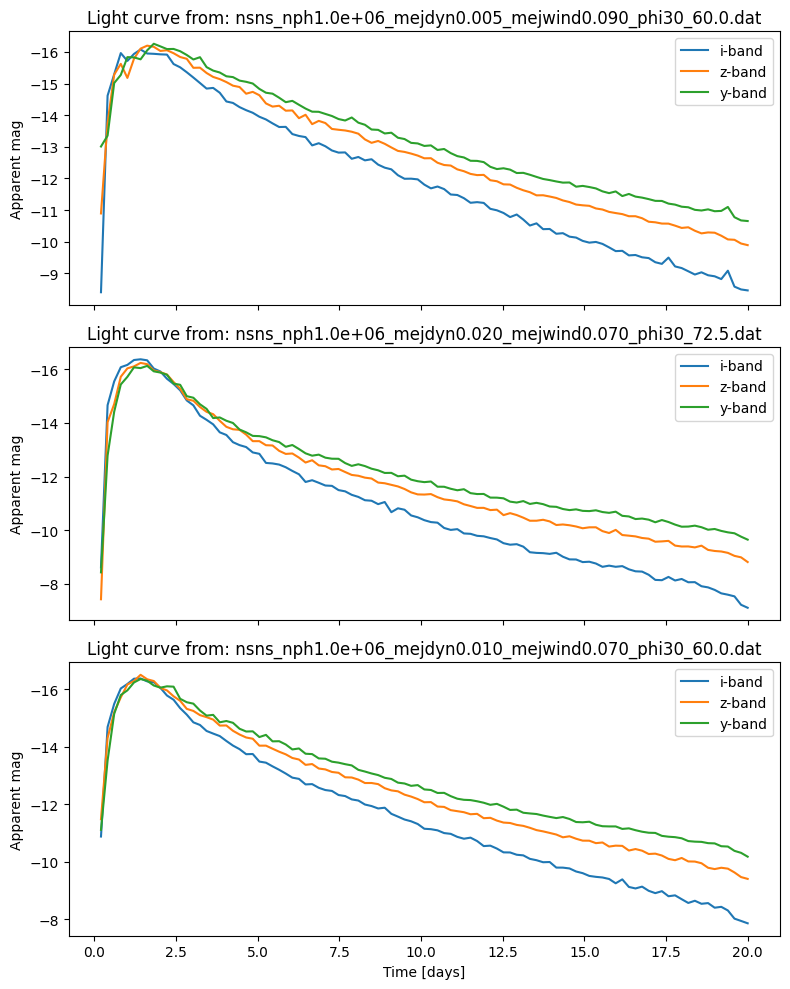

In [199]:
# Re-import libraries due to kernel reset
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

# Load light curve template metadata
template_file = "kne_templates_used.pkl"
with open(template_file, "rb") as f:
    templates = pickle.load(f)

# Load and parse 3 red-peaking templates from the selected ones
sample_files = [entry["filename"] for entry in templates[:3]]

# Filters and column indices for ugrizy
filters = ['u', 'g', 'r', 'i', 'z', 'y']
col_indices = dict(zip(filters, range(1, 7)))

# Plot each filter's light curve for each selected file
fig, axs = plt.subplots(len(sample_files), 1, figsize=(8, 10), sharex=True)

for i, file in enumerate(sample_files):
    try:
        data = np.loadtxt(file)
        time = data[:, 0]
        for f in ['i', 'z', 'y']:
            mag = data[:, col_indices[f]]
            axs[i].plot(time, mag, label=f'{f}-band')
        axs[i].invert_yaxis()
        axs[i].set_ylabel("Apparent mag")
        axs[i].legend()
        axs[i].set_title(f"Light curve from: {os.path.basename(file)}")
    except Exception as e:
        axs[i].set_title(f"Error reading {file}: {e}")

axs[-1].set_xlabel("Time [days]")
plt.tight_layout()
plt.show()
